# **Single-Cell RNA-Seq Analysis Project**

In this project, you will work with the `norman` dataset from the `perturbation_data_analysis` exercise:

In [17]:
!pip install umap-learn

In [18]:
# from models import Autoencoder
import umap
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [19]:
import os
import sys

# Append the root of the Git repository to the path.
git_root = os.popen(cmd="git rev-parse --show-toplevel").read().strip()
sys.path.append(git_root)

from src.exercises.perturbation_data_analysis import pertdata as pt  # noqa: E402

norman = pt.PertData.from_repo(name="norman", save_dir="data")

print(norman)

Dataset directory already exists: data\norman
Loading dataset: norman
PertData object
    name: norman
    path: data\norman
    adata: AnnData object with n_obs x n_vars = 91205 x 5045


**Exploratory Data Analysis and Visualization**

In [20]:
print(norman)
print(norman.adata)

X = norman.adata.X
y_pert = norman.adata.obs["condition"]
y_ctrl = norman.adata.obs["control"]
gene_names = norman.adata.var["gene_name"]

print(f"X.shape={X.shape}")  # type: ignore
print(f"y_pert.shape={y_pert.shape}")
print(f"y_ctrl.shape={y_ctrl.shape}")
print(f"gene_names.shape={gene_names.shape}")

PertData object
    name: norman
    path: data\norman
    adata: AnnData object with n_obs x n_vars = 91205 x 5045
AnnData object with n_obs × n_vars = 91205 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'condition_fixed'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    layers: 'counts'
X.shape=(91205, 5045)
y_pert.shape=(91205,)
y_ctrl.shape=(91205,)
gene_names.shape=(5045,)


In [21]:
print(f"Unique perturbations (unfixed): {len(set(norman.adata.obs['condition']))}")
print(f"Unique perturbations (fixed): {len(set(norman.adata.obs['condition_fixed']))}")

Unique perturbations (unfixed): 284
Unique perturbations (fixed): 237


**Filtering out double gene perturbations**

In [22]:
filter_mask = ~norman.adata.obs["condition_fixed"].str.contains(r"\+")
indexes_to_keep = filter_mask[filter_mask].index
adata_single = norman.adata[indexes_to_keep].copy()  # type: ignore

In [23]:
print(filter_mask)
print(indexes_to_keep)
print(adata_single)

print("")
print(f"Unique perturbations: {len(set(adata_single.obs['condition_fixed']))}")
print("Number of samples per condition:")
print(adata_single.obs["condition_fixed"].value_counts())

cell_barcode
AAACCTGAGGCATGTG-1     True
AAACCTGAGGCCCTTG-1    False
AAACCTGCACGAAGCA-1     True
AAACCTGCAGACGTAG-1    False
AAACCTGCAGCCTTGG-1     True
                      ...  
TTTGTCAGTCATGCAT-8    False
TTTGTCATCAGTACGT-8     True
TTTGTCATCCACTCCA-8     True
TTTGTCATCCCAACGG-8     True
TTTGTCATCTGGCGAC-8     True
Name: condition_fixed, Length: 91205, dtype: bool
Index(['AAACCTGAGGCATGTG-1', 'AAACCTGCACGAAGCA-1', 'AAACCTGCAGCCTTGG-1',
       'AAACCTGCATCTCCCA-1', 'AAACCTGGTATAATGG-1', 'AAACCTGGTCTGATTG-1',
       'AAACCTGGTTTCCACC-1', 'AAACCTGTCAGGCGAA-1', 'AAACCTGTCCGATATG-1',
       'AAACCTGTCCGTAGTA-1',
       ...
       'TTTGTCACATCGTCGG-8', 'TTTGTCAGTACCTACA-8', 'TTTGTCAGTACGCTGC-8',
       'TTTGTCAGTAGCGTGA-8', 'TTTGTCAGTAGGCATG-8', 'TTTGTCAGTCAGAATA-8',
       'TTTGTCATCAGTACGT-8', 'TTTGTCATCCACTCCA-8', 'TTTGTCATCCCAACGG-8',
       'TTTGTCATCTGGCGAC-8'],
      dtype='object', name='cell_barcode', length=55760)
AnnData object with n_obs × n_vars = 55760 × 5045
    obs: 'cond

**Selecting highest variances**

In [24]:
# Number of top genes to select.
d = 128

# Compute the gene variances.
gene_variances = adata_single.X.toarray().var(axis=0)  # type: ignore

# Sort the gene variances in descending order and get the indexes of the top d genes.
sorted_indexes = gene_variances.argsort()[::-1]

# Get the indexes of the top d genes.
top_gene_indexes = sorted_indexes[:d]

# Get the gene names of the top d genes.
top_genes = adata_single.var["gene_name"].iloc[top_gene_indexes]

# Get the variances of the top d genes.
top_variances = gene_variances[top_gene_indexes]

# Print the top d genes with the highest variances.
print(f"Top {d} genes with highest variances:")
for gene, variance in zip(top_genes, top_variances):
    print(f"{gene:15}: {variance:.2f}")
    # print(str(gene) + ", " + str(variance))

# Create a new AnnData object with only the top d genes.
adata_single_top_genes = adata_single[:, top_gene_indexes].copy()

Top 128 genes with highest variances:
HBZ            : 1.69
HIST1H4C       : 1.69
HBG2           : 1.15
HIST1H1C       : 0.85
HBG1           : 0.73
NEAT1          : 0.71
UBE2S          : 0.62
GYPB           : 0.61
MALAT1         : 0.58
TOP2A          : 0.58
VIM            : 0.57
HMGB2          : 0.56
SH3BGRL3       : 0.55
RP11-301G19.1  : 0.53
HIST1H2BJ      : 0.52
CENPF          : 0.49
GAL            : 0.48
MT-ND6         : 0.48
RP11-717F1.1   : 0.47
APOE           : 0.47
PTTG1          : 0.47
CKS1B          : 0.47
CKS2           : 0.46
TUBB           : 0.46
GYPA           : 0.46
KIAA0101       : 0.46
S100A11        : 0.45
PHF19          : 0.44
PSMA4          : 0.44
HNRNPH1        : 0.44
CACYBP         : 0.43
KRT18          : 0.43
BTG1           : 0.43
LDHA           : 0.43
SLC25A37       : 0.42
CFD            : 0.42
AIF1           : 0.42
LGALS1         : 0.41
NME1           : 0.41
HSPA8          : 0.41
BLVRB          : 0.41
HN1            : 0.41
SRM            : 0.41
BIRC5          :

**scRNA-Seq Data Prep**

In [25]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# Convert the gene expression matrix to a PyTorch tensor.
X = torch.tensor(data=adata_single_top_genes.X.toarray(), dtype=torch.float32)  # type: ignore

# Create a PyTorch dataset.
dataset = TensorDataset(X, X)

# Create train and test datasets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(
    dataset=dataset, lengths=[train_size, test_size]
)

# Number of workers.
num_workers = 3

# Create train and test data loaders.
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=num_workers,
    persistent_workers=True,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=num_workers,
    persistent_workers=True,
)

**Create auto-encoder**

In [26]:
import pytorch_lightning as pl
from models import Autoencoder

# Get the number of features.
n_features = X.shape[1]
print(f"n_features={n_features}")

# Get the number of samples.
n_samples = X.shape[0]  # = len(train_dataset) + len(test_dataset) = len(dataset)
print(f"n_samples={n_samples}")

# Create the autoencoder
autoencoder = Autoencoder(in_features=n_features)

AttributeError: module 'sympy' has no attribute 'printing'

**Train auto-encoder**

In [13]:
from pytorch_lightning.loggers import CSVLogger

# Initialize the CSV logger.
logger = CSVLogger(save_dir="lightning_logs", name="ae_experiment")

# Train the autoencoder.
trainer = pl.Trainer(max_epochs=4, logger=logger)
trainer.fit(model=autoencoder, train_dataloaders=train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 12.4 K | train
1 | decoder | Decoder | 12.5 K | train
2 | loss_fn | MSELoss | 0      | train
--------------------------------------------
24.9 K    Trainable params
0         Non-trainable params
24.9 K    Total params
0.100     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 697/697 [00:19<00:00, 35.26it/s, v_num=1, batch_idx=696.0, train_loss=0.189]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 697/697 [00:19<00:00, 35.08it/s, v_num=1, batch_idx=696.0, train_loss=0.189]


In [14]:
# Test the autoencoder.
trainer.test(model=autoencoder, dataloaders=test_loader)

Testing DataLoader 0: 100%|██████████| 175/175 [00:01<00:00, 87.64it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.19969652593135834
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.19969652593135834}]

logfile=lightning_logs\ae_experiment\version_1\metrics.csv


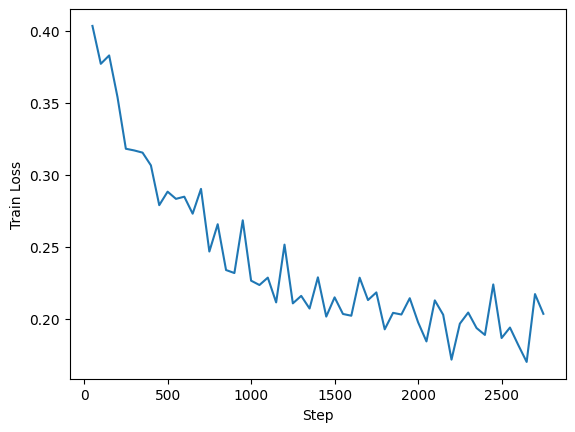

In [15]:
import os

import matplotlib.pyplot as plt
import pandas as pd


def plot_train_loss(logfile: str) -> None:
    """Plot the training loss from a PyTorch Lightning log file."""
    print(f"logfile={logfile}")
    log = pd.read_csv(filepath_or_buffer=logfile)
    plt.plot(log["step"], log["train_loss"])
    plt.xlabel("Step")
    plt.ylabel("Train Loss")
    plt.show()


# Construct the path to the most recent version directory.
most_recent_metrics_file = os.path.join(
    logger.save_dir, logger.name, f"version_{logger.version}", "metrics.csv"
)

# Plot the training loss.
plot_train_loss(logfile=most_recent_metrics_file)

In [6]:
# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(dataset)

# Check the shape of the reduced data
print(f"UMAP embedding shape: {embedding.shape}")

NameError: name 'dataset' is not defined

In [ ]:
# Visualize UMAP output
plt.figure(figsize=(10, 8))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, palette='viridis', s=50)
plt.title('UMAP Projection of the Dataset')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Labels', loc='best')
plt.show()

Choose one of the following tasks:

**Exploratory Data Analysis and Visualization**

- Objective: Explore the dataset to identify patterns and clusters.
- Tasks:
  - Perform dimensionality reduction using PCA, t-SNE, or UMAP.
  - Visualize gene expression profiles across different conditions or perturbations.
  - Create heatmaps of the top differentially expressed genes.
- Learning Outcomes:
  - Learn to visualize high-dimensional data.
  - Interpret clusters and patterns in the context of biological conditions.

**Machine Learning Classification**

- Objective: Build models to classify samples based on gene expression profiles.
- Tasks:
  - Split the dataset into training and testing sets.
  - Implement classification algorithms.
  - Evaluate model performance using metrics like accuracy, precision, recall, and ROC curves.
- Learning Outcomes:
  - Understand supervised learning techniques.
  - Learn model evaluation and validation strategies.

**Advanced Deep Learning Applications**

- Objective: Apply deep learning techniques to model complex patterns in the data.
- Tasks:
  - Implement autoencoders or variational autoencoders for dimensionality reduction.
  - Explore the use of GANs to generate synthetic gene expression data.
  - Analyze how deep learning models capture nonlinear relationships.
- Learning Outcomes:
  - Gain experience with deep learning frameworks.
  - Understand the applications of deep learning in genomics.